In [ ]:
import tensorflow_datasets as tfds
dataset, info = tfds.load("cifar10",with_info=True)

dataset, info

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

Generating splits...:   0%|          | 0/2 [00:00<?, ? splits/s]

Generating train examples...: 0 examples [00:00, ? examples/s]

Shuffling /root/tensorflow_datasets/cifar10/incomplete.P6ZUS0_3.0.2/cifar10-train.tfrecord*...:   0%|         …

Generating test examples...: 0 examples [00:00, ? examples/s]

Shuffling /root/tensorflow_datasets/cifar10/incomplete.P6ZUS0_3.0.2/cifar10-test.tfrecord*...:   0%|          …

Dataset cifar10 downloaded and prepared to /root/tensorflow_datasets/cifar10/3.0.2. Subsequent calls will reuse this data.


({Split('train'): <_PrefetchDataset element_spec={'id': TensorSpec(shape=(), dtype=tf.string, name=None), 'image': TensorSpec(shape=(32, 32, 3), dtype=tf.uint8, name=None), 'label': TensorSpec(shape=(), dtype=tf.int64, name=None)}>,
  Split('test'): <_PrefetchDataset element_spec={'id': TensorSpec(shape=(), dtype=tf.string, name=None), 'image': TensorSpec(shape=(32, 32, 3), dtype=tf.uint8, name=None), 'label': TensorSpec(shape=(), dtype=tf.int64, name=None)}>},
 tfds.core.DatasetInfo(
     name='cifar10',
     full_name='cifar10/3.0.2',
     description="""
     The CIFAR-10 dataset consists of 60000 32x32 colour images in 10 classes, with 6000 images per class. There are 50000 training images and 10000 test images.
     """,
     homepage='https://www.cs.toronto.edu/~kriz/cifar.html',
     data_dir='/root/tensorflow_datasets/cifar10/3.0.2',
     file_format=tfrecord,
     download_size=162.17 MiB,
     dataset_size=132.40 MiB,
     features=FeaturesDict({
         'id': Text(shape=(),

###Preprocessing
We will now convert all images into grayscale and take it as `input(x)`, the original images (color ones) are taken as `target(y)`.

In [ ]:
import tensorflow as tf

IMG_SIZE=128

def preprocessing(example):
  image = tf.image.resize(example["image"],(IMG_SIZE,IMG_SIZE))
  image = tf.cast(image,tf.float32) / 255.0 #Normalizing to [0,1]

  #RGB --> B&W
  gray = tf.image.rgb_to_grayscale(image)  #Input(X)

  #color as it was
  color = image                            #Target(Y)

  return (gray,color)    #return {"gray":gray, "color": color}

>**Code BreakDown**
* `image = tf.image.resize(example["image"],(IMG_SIZE,IMG_SIZE))` : *The image will be enlarged/compressed to a given size `IMG_SIZE=128`. so every image is (128x128).
* `image = tf.cast(image,tf.float32) / 255.0` : The DataType of the image isset to `float32` and that decimal form of image is divide by `255.0` to achive normalization {values lie b/w 0 & 1}.
* `train_ds = dataset["train"].map(preprocessing)` &
`test_ds = dataset["test"].map(preprocessing)`: *map applies your preprocessing function to every example in the train-dataset and test-dataset, transforming it (like normalization, resizing, etc.) before feeding it to the model.*

In [ ]:
train_ds = dataset["train"].map(preprocessing)
test_ds = dataset["test"].map(preprocessing)
train_ds, test_ds

(<_MapDataset element_spec=(TensorSpec(shape=(128, 128, 1), dtype=tf.float32, name=None), TensorSpec(shape=(128, 128, 3), dtype=tf.float32, name=None))>,
 <_MapDataset element_spec=(TensorSpec(shape=(128, 128, 1), dtype=tf.float32, name=None), TensorSpec(shape=(128, 128, 3), dtype=tf.float32, name=None))>)

##**Optimize Dataset for Training**
* Before feeding data into a model, prepare it for efficient I/O:
* Shuffle (only for training)
* Batch
* Prefetch (for performance)

In [ ]:
BATCH_SIZE = 32
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.shuffle(1000).batch(BATCH_SIZE).prefetch(AUTOTUNE)
test_ds = test_ds.batch(BATCH_SIZE).prefetch(AUTOTUNE)

train_ds,test_ds

(<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 128, 128, 1), dtype=tf.float32, name=None), TensorSpec(shape=(None, 128, 128, 3), dtype=tf.float32, name=None))>,
 <_PrefetchDataset element_spec=(TensorSpec(shape=(None, 128, 128, 1), dtype=tf.float32, name=None), TensorSpec(shape=(None, 128, 128, 3), dtype=tf.float32, name=None))>)

>**Code BreakDown**

* `BATCH_SIZE = 32` : *Instead of feeding one image at a time, we process 32 images together in one forward pass.

--> Speeds up training using vectorized operations.
--> Stabilizes gradient estimates.

* `AUTOTUNE = tf.data.AUTOTUNE` : tells TensorFlow to automatically tune the level of parallelism for operations like map() and prefetch().

--> Benefit: TensorFlow figures out the best performance settings for your CPU/GPU without you manually tweaking them.

* `train_ds = train_ds.shuffle(1000)` : Randomizes the order of the dataset each epoch (to prevent the model from learning spurious patterns from data order).

--> 1000 = buffer size → means it holds 1000 samples in memory and randomly picks from them.

--> Larger buffer = better randomness, but uses more memory.

* `.batch(BATCH_SIZE)` : Groups 32 samples into one batch. Output shape after this: (32, IMG_SIZE, IMG_SIZE, channels) for images.

* `.prefetch(AUTOTUNE)` : Prefetching = while the model is training on one batch, prepare the next batch in the background.

--> Improves GPU utilization (avoids idle time waiting for data).

--> AUTOTUNE lets TensorFlow decide the best prefetch buffer size.
* `test_ds = test_ds.batch(BATCH_SIZE).prefetch(AUTOTUNE)` : All same but no Shuffle.

In [ ]:
from tensorflow.keras import layers, models

#U-net Building Blocks

#Convolution Block
def conv_block(x, filters, dropout=0.0):
  x = layers.Conv2D(filters, kernel_size=(3,3), padding="same", kernel_initializer="he_normal")(x)
  x = layers.BatchNormalization()(x)
  x = layers.ReLU()(x)
  if dropout > 0.0:
    x = layers.Dropout(dropout)(x)
  return x

#DownSampling (Convolution+pooling)
def Down_block(x, filters, dropout=0.0):
  c = conv_block(x, filters, dropout)
  p = layers.MaxPooling2D((2,2))(c)
  return c , p

#UpSampling
def Up_block(x, skip, filters, dropout=0.0):
  x = layers.UpSampling2D((2,2))(x)
  x = layers.Concatenate()([x, skip])
  x = conv_block(x, filters, dropout)
  return x

#Building U-net
def build_colorful_model(input_shape=(128,128,1), base_filters=64, dropout=0.0):
  inputs = layers.Input(shape=input_shape, name="gray")

  #Encoder
  c1, p1 = Down_block(inputs, base_filters, dropout)  #64 filters
  c2, p2 = Down_block(p1, base_filters*2, dropout)    #64*2=128 filters
  c3, p3 = Down_block(p2, base_filters*4, dropout)    #64*4=256 filters
  c4, p4 = Down_block(p3, base_filters*8, dropout)    #64*8=512 filters


  #Bottel Neck
  bn = conv_block(p4, base_filters*16, dropout)      #'conv_block': since there will be no pooling in BottelNeck, 64*16=1024


  #Decoder
  u1 = Up_block(bn, c4, base_filters*8, dropout)     #64*8=512 filters (used to UpSample the tensor and concate c4 {skip connection})
  u2 = Up_block(u1, c3, base_filters*4, dropout)     #64*4=256 filters (used to UpSample the tensor and concate c3 {skip connection})
  u3 = Up_block(u2, c2, base_filters*2, dropout)     #64*2=128 filters (used to UpSample the tensor and concate c2 {skip connection})
  u4 = Up_block(u3, c1, base_filters, dropout)       #64 filters (used to UpSample the tensor and concate c1 {skip connection})

  #output
  outputs = layers.Conv2D(3, (1,1), padding="same", activation="sigmoid")(u4)

  return models.Model(inputs, outputs, name="UNet_chitraranga_model")

##**UNet Architecture**

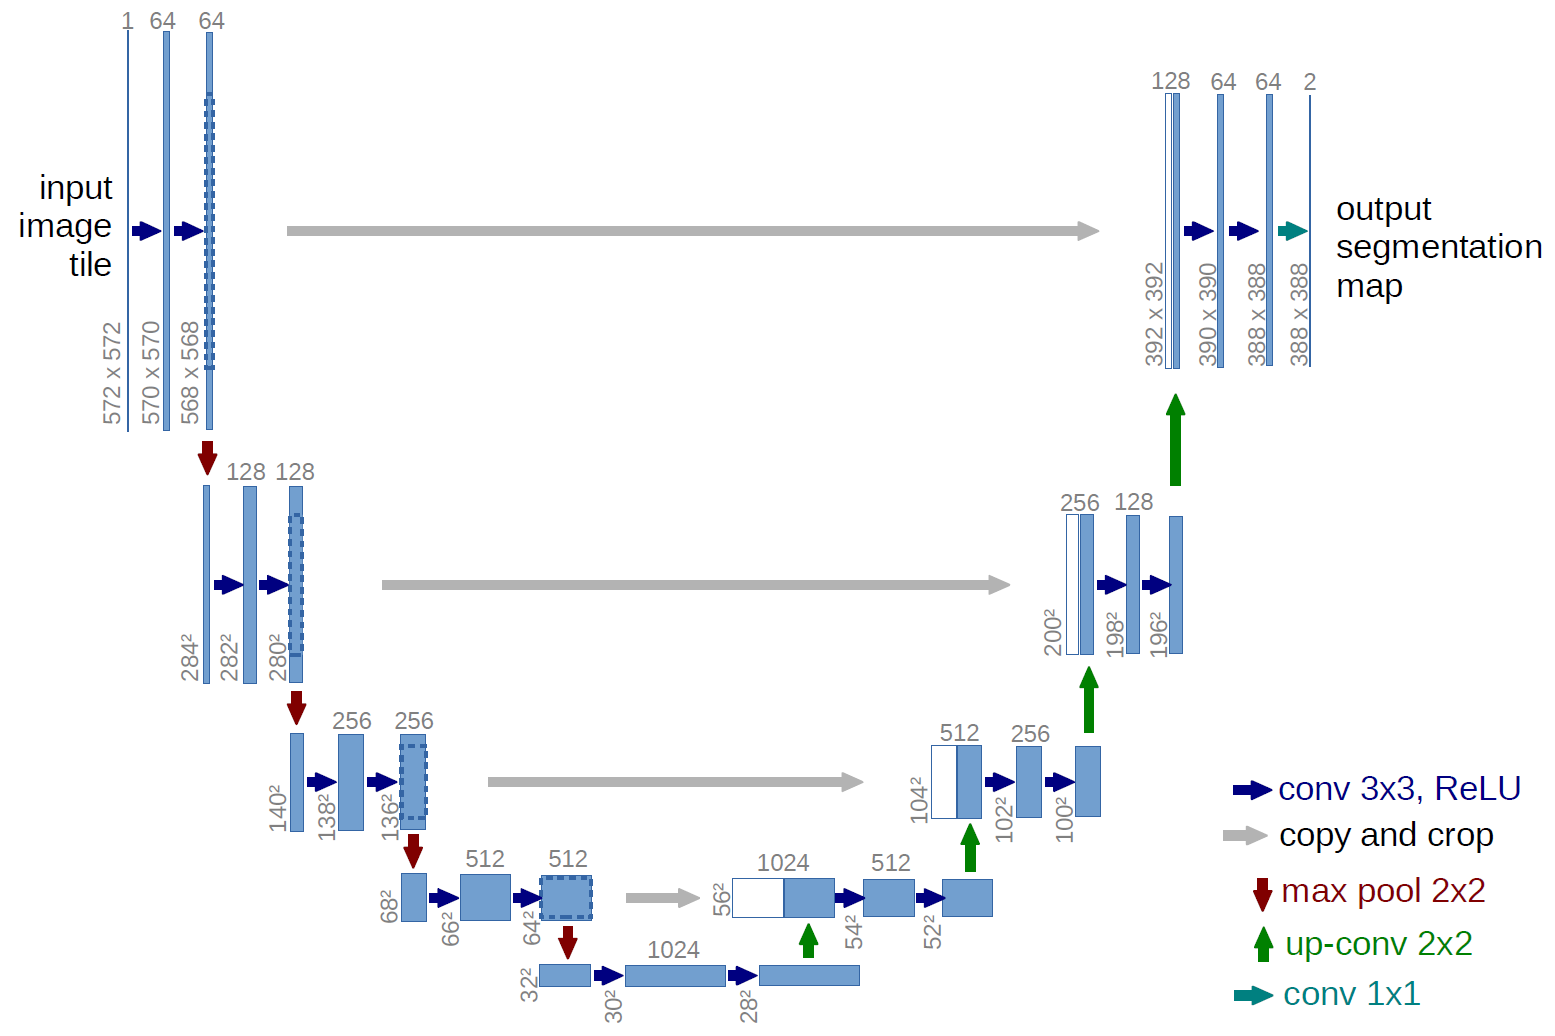

>**Code BreakDown**

* `x = layers.Conv2D(filters, kernel_size=(3,3), padding="same", kernel_initializer="he_noraml")(x)` : Here we are using Conv2D from layers which takes no.of filters, size of kernel, how much padding, weights initializer as parameters.

  - `Conv2D(64, (3,3))` → `64` filters, each of size `3×3`

    `c1, p1 = Down_block(inputs, base_filters, dropout)` in code.

  - `Conv2D(128, (3,3))` → `128` filters, each of size `3×3`

    `c2, p2 = Down_block(p1, base_filters*2, dropout)` in code.

  - `Conv2D(256, (3,3))` → `256` filters, each of size `3×3`

    `c3, p3 = Down_block(p2, base_filters*4, dropout)` in code.

  - `Conv2D(512, (3,3))` → `512` filters, each of size `3×3`

    `c4, p4 = Down_block(p3, base_filters*8, dropout)` in code.

* Then, on the way back in the decoder, it reduces: 128 filters -> 64 filters

* Finally 3 filters (because output image is RGB)

* `(3,3)` : This is the kernel size of the convolution filter, means each filter looks at a 3×3 patch of the input image (or feature map) at a time.

* `(2,2)` :

  `MaxPooling2D((2,2))` : Downsamples feature maps by taking the maximum in each 2×2 block → halves width and height.
  
  Example: 128×128 → 64×64

  `UpSampling2D((2,2))` : Opposite of pooling → doubles the width and height by replicating values.
  
  Example: 32×32 → 64×64

***Videos Explaining UpSampling and Skip connection***
* **UpSampling:** https://youtu.be/QmCxqsbn5B0?si=7wHfIJnq_jwHpsCh
* **Skip Connection:** https://youtu.be/Q1JCrG1bJ-A?si=HHlW58nW83PBpVIJ

##The Structure
ENCODER ➡️ BOTTLE NECK ➡️ DECODER ➡️ OUTPUT

In [ ]:
#Compiling the model
model = build_colorful_model(input_shape=(128,128,1), base_filters=64, dropout=0.0)

#PSNR function
def psnr(y_true,y_pred):
  return tf.image.psnr(y_true, y_pred, max_val=1.0)

model.compile(optimizer= tf.keras.optimizers.Adam(1e-3), loss="mse", metrics=[psnr,"mae"])
model.summary()

Model: "UNet_chitraranga_model"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ gray (InputLayer)   │ (None, 128, 128,  │          0 │ -                 │
│                     │ 1)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 128, 128,  │        640 │ gray[0][0]        │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalization │ (None, 128, 128,  │        256 │ conv2d[0][0]      │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu (ReLU)        │ (None, 128, 128,  │          0 │ batch_normalizat… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d       │ (None, 64, 64,    │          0 │ re_lu[0][0]       │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 64, 64,    │     73,856 │ max_pooling2d[0]… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 64, 64,    │        512 │ conv2d_1[0][0]    │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu_1 (ReLU)      │ (None, 64, 64,    │          0 │ batch_normalizat… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_1     │ (None, 32, 32,    │          0 │ re_lu_1[0][0]     │
│ (MaxPooling2D)      │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 32, 32,    │    295,168 │ max_pooling2d_1[… │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 32, 32,    │      1,024 │ conv2d_2[0][0]    │
│ (BatchNormalizatio… │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu_2 (ReLU)      │ (None, 32, 32,    │          0 │ batch_normalizat… │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_2     │ (None, 16, 16,    │          0 │ re_lu_2[0][0]     │
│ (MaxPooling2D)      │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_3 (Conv2D)   │ (None, 16, 16,    │  1,180,160 │ max_pooling2d_2[… │
│                     │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 16, 16,    │      2,048 │ conv2d_3[0][0]    │
│ (BatchNormalizatio… │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu_3 (ReLU)      │ (None, 16, 16,    │          0 │ batch_normalizat… │
│                     │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_3     │ (None, 8, 8, 512) │          0 │ re_lu_3[0][0]   

 Total params: 15,682,691 (59.82 MB)

 Trainable params: 15,676,803 (59.80 MB)

 Non-trainable params: 5,888 (23.00 KB)

> **Code BreakDown**
* The model is compiled with the optimizer as `adam` and loss-function as `mse`(Mean_squared_error).
* ✔ **Model compilation:** It configures the model with an optimizer, loss function, and metrics so it knows how to learn during training.

* ✔ **Adam optimizer:** It adjusts weights using adaptive learning rates and momentum for faster, stable convergence.

* ✔ `Adam(1e-3)`: 1e-3 means 0.001 → the learning rate.

* **Why 1e-3?** It’s a common starting value for Adam because it balances convergence speed and stability.

* **Smaller value** → slower, stable learning. **Larger value** → faster, but risk of divergence.

* ✔ **`MSE` (Mean Squared Error):** It measures the average squared difference between predicted and actual pixel values, penalizing large errors more.

   ***PSNR:***
   - PSNR = Peak Signal-to-Noise Ratio.

  - It measures image quality by comparing your predicted image `(y_pred)` to the original image `(y_true)`.

  - Higher PSNR means the reconstructed image is closer to the original (better quality).

  - `max_val=1.0` means your pixel values are normalized between 0 and 1.
    (If your images were 0–255, you would set max_val=255.0).
* `MAE` (Mean Absolute Error): average of absolute differences between predicted and true pixels.

* MAE is easier to interpret but less sensitive to outliers than MSE.


In [ ]:
#ModelCheckPoint
ckpt = tf.keras.callbacks.ModelCheckpoint(
    "UNet_chitraranga_model.h5",
    monitor = "val_psnr",
    mode = "max",                         #The higher th psnr -> the higher the image quality.
    save_best_only = True,
    verbose = 1
)

#EarlyStopping
es = tf.keras.callbacks.EarlyStopping(
    monitor = "val_psnr",
    mode = "max",
    patience = 5,                       #Check until 5 epochs, if the pnsr is low: Stop training.
    restore_best_weights = True
)

#Reduce Learning Rate
rlr = tf.keras.callbacks.ReduceLROnPlateau(
    monitor = "val_loss",
    factor = 0.5,
    patience = 3,                     #Check until 3 epochs, if the Learning_rate is stuck then reduce it (divide) by factor {i.e, LR*0.5}
    verbose = 1
)

>**Code BreakDown**

###Model Checkpoint
ModelCheckpoint is a Keras callback that saves the model during training.

* `monitor="val_psnr"` → It watches the validation PSNR metric after each epoch.

* `mode="max"` → Because higher PSNR is better (unlike loss, where lower is better).

* `save_best_only=True` → It only saves the model when val_psnr improves.

* `verbose=1` → Prints a message when the model is saved.

###Early Stopping
Stops training early if the monitored metric does not improve for a given number of epochs.

* `monitor="val_psnr"` → We track validation PSNR.

* `mode="max"` → Higher is better.

* `patience=5` → If PSNR does not improve for 5 consecutive epochs, stop training.

* `restore_best_weights=True` → After stopping, restore weights of the best epoch.
* This will prevent overfitting and saves time.

###Reduce Learning Rate
Reduces the learning rate when the monitored metric (validation_loss) stops improving.

* `monitor="val_loss"` → It checks validation loss.

* `factor=0.5` → Reduce LR by half (new_lr = old_lr * 0.5).

* `patience=3` → Wait 3 epochs without improvement before reducing LR.

* `verbose=1` → Print when LR changes.

* Sometimes the model gets stuck, and lowering LR helps find a better minimum.

In [15]:
#Training
history = model.fit(
    train_ds,
    validation_data = test_ds,
    epochs = 30,
    steps_per_epoch=1000,
    callbacks = [ckpt,es,rlr]
)

Epoch 1/30
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 0s 254ms/step - loss: 0.0048 - mae: 0.0443 - psnr: 25.2417
Epoch 1: val_psnr did not improve from 25.38512
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 296s 295ms/step - loss: 0.0048 - mae: 0.0443 - psnr: 25.2417 - val_loss: 0.0046 - val_mae: 0.0432 - val_psnr: 25.3691 - learning_rate: 1.9531e-06
Epoch 2/30
 563/1000 ━━━━━━━━━━━━━━━━━━━━ 1:51 254ms/step - loss: 0.0046 - mae: 0.0436 - psnr: 25.3736
Epoch 2: val_psnr did not improve from 25.38512
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 184s 184ms/step - loss: 0.0046 - mae: 0.0436 - psnr: 25.3740 - val_loss: 0.0046 - val_mae: 0.0433 - val_psnr: 25.3725 - learning_rate: 1.9531e-06
Epoch 3/30
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 0s 255ms/step - loss: 0.0048 - mae: 0.0443 - psnr: 25.2275
Epoch 3: val_psnr did not improve from 25.38512
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 296s 296ms/step - loss: 0.0048 - mae: 0.0443 - psnr: 25.2275 - val_loss: 0.0046 - val_mae: 0.0433 - val_psnr: 25.3585 - learning_rate: 1.9531e-06
Epoch 4/30
 563/1000

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 169ms/step


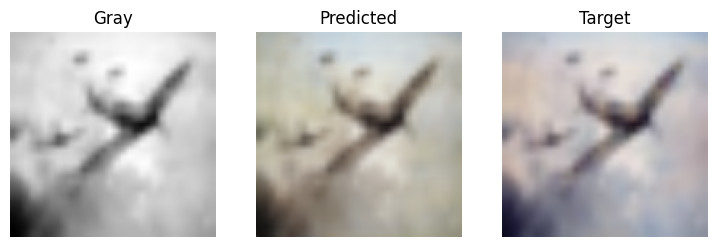

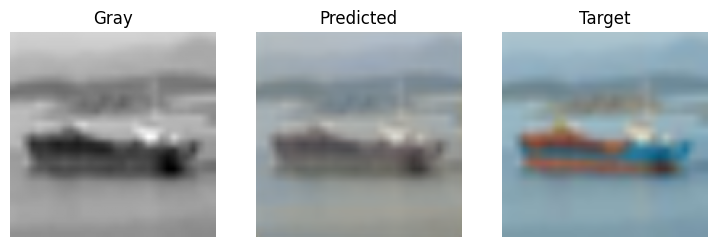

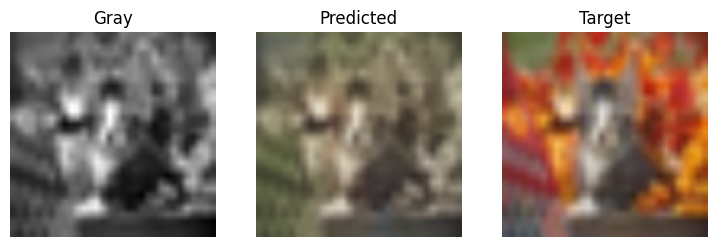

In [16]:
#Quick Inference Preview
import matplotlib.pyplot as plt

gray_batch, color_batch = next(iter(train_ds))
pred = model.predict(gray_batch)

# Show 3 samples: input gray | predicted color | true color
for i in range(3):
  plt.figure(figsize=(9,3))

  #Gray image
  plt.subplot(1,3,1)
  plt.title("Gray")
  plt.imshow(tf.squeeze(gray_batch[i]), cmap="gray")
  plt.axis("off")

  #Predicted color image
  plt.subplot(1,3,2)
  plt.title("Predicted")
  plt.imshow(pred[i])
  plt.axis("off")

  #Target color image
  plt.subplot(1,3,3)
  plt.title("Target")
  plt.imshow(color_batch[i])
  plt.axis("off")

  plt.show()

In [17]:
#Saving the model as HDF5 (.h5)
model.save("UNet_chitraranga_model.h5")